# Soil Moisture Active Passive (SMAP) Level 4 Data demo for Mato Grosso (Brazil)
In this demo we are downloading data using Planet OS Package-API which let's us use bigger amount of data with less time than raster API. 

In [3]:
%matplotlib inline
import time
import os
from package_api import download_data
import xarray as xr
from netCDF4 import Dataset, num2date
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

<font color='red'>Please put your datahub API key into a file called APIKEY and place it to the notebook folder or assign your API key directly to the variable API_key!</font>

In [4]:
API_key = open('APIKEY').read().strip()

Here we define the area we are intrested, time range from where we want to have the data, dataset key to use and variable name.

In [5]:
latitude_north = 5.8; latitude_south = -32
longitude_west = -73; longitude_east = -33

area = 'brazil'
time_start = '2017-10-15T16:00:00'
time_end = '2017-10-15T19:00:00' 
dataset_key = 'nasa_smap_spl4smau'
variable = 'Analysis_Data_sm_surface_analysis'

This one here is generating working directory, we need it to know where we are going to save data. No worries, we will delete file after using it! 

In [6]:
folder = os.path.realpath('.') + '/'

Now we ara making a function for making images 

In [7]:
def make_image(lon,lat,data,date,latitude_north, latitude_south,longitude_west, longitude_east,unit,**kwargs):
    m = Basemap(projection='merc', lat_0 = 55, lon_0 = -4,
         resolution = 'i', area_thresh = 0.05,
         llcrnrlon=longitude_west, llcrnrlat=latitude_south,
         urcrnrlon=longitude_east, urcrnrlat=latitude_north)
    lons,lats = np.meshgrid(lon,lat)
    lonmap,latmap = m(lons,lats)
    
    if len(kwargs) > 0:
        fig=plt.figure(figsize=(10,8))
        plt.subplot(221)
        m.drawcoastlines()
        m.drawcountries()
        c = m.pcolormesh(lonmap,latmap,data,vmin = 0.01,vmax = 0.35)
        plt.title(date)
        
        plt.subplot(222)
        m.drawcoastlines()
        m.drawcountries()
        plt.title(kwargs['date_later'])
        m.pcolormesh(lonmap,latmap,kwargs['data_later'],vmin = 0.01,vmax = 0.35)
        
        
        
    else:
        fig=plt.figure(figsize=(9,7))
        m.drawcoastlines()
        m.drawcountries()
        c = m.pcolormesh(lonmap,latmap,data,vmin = 0.01,vmax = 0.35)
        plt.title(date)
    
    cbar = plt.colorbar(c)
    cbar.set_label(unit)
    plt.show()

Here we are downloading data by using Package-API. If you are intrested how data is downloaded, find the file named `package_api.py` from notebook folder.

In [8]:
package_key = download_data(folder,dataset_key,API_key,longitude_west,longitude_east,latitude_south,latitude_north,time_start,time_end,variable,area)

file already exists, no need to download other one


Now we have data and we are reading it in using xarray:

In [9]:
filename_s_america = package_key + '.nc'
data = xr.open_dataset(filename_s_america)
surface_soil_moisture_data = data.Analysis_Data_sm_surface_analysis
unit = surface_soil_moisture_data.units
surface_soil_moisture = data.Analysis_Data_sm_surface_analysis.values[0,:,:]
surface_soil_moisture= np.ma.masked_where(np.isnan(surface_soil_moisture),surface_soil_moisture)

latitude = data.lat; longitude = data.lon
lat = latitude.values
lon = longitude.values
date = str(data.time.values[0])[:-10]

Here we are making image by using function defined above. 

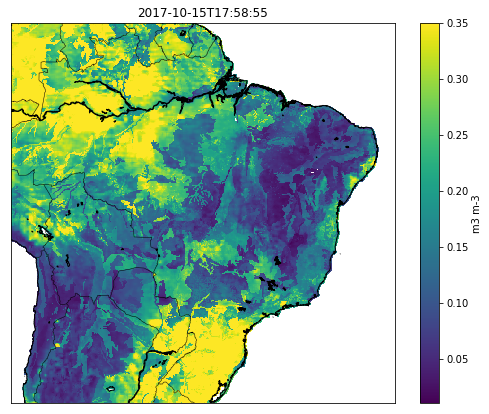

In [10]:
make_image(lon,lat,surface_soil_moisture,date,latitude_north, latitude_south,longitude_west, longitude_east,unit)

So let's see Mato Grosso littlebit closer. For that we need to define the area and we will slice data from this area. 

In [11]:
grosso_west = -61.6; grosso_east = -50.2
grosso_south = -18; grosso_north = -7.2

lon_gr = longitude.sel(lon=slice(grosso_west,grosso_east)).values
lat_gr = latitude.sel(lat=slice(grosso_north,grosso_south)).values
soil_gr = surface_soil_moisture_data.sel(lat=slice(grosso_north,grosso_south),lon=slice(grosso_west,grosso_east)).values[0,:,:]
soil_gr = np.ma.masked_where(np.isnan(soil_gr),soil_gr)

Let's also import some data from 21th October 

In [12]:
time_start = '2017-10-21T15:00:00'
time_end = '2017-10-21T19:00:00'
package_key_grosso = download_data(folder,dataset_key,API_key,grosso_west,grosso_east,grosso_south,grosso_north,time_start,time_end,variable,area)

filename_mato_grosso = package_key_grosso + '.nc'
data_later = xr.open_dataset(filename_mato_grosso)
soil_data_later = data_later.Analysis_Data_sm_surface_analysis
soil_later = data_later.Analysis_Data_sm_surface_analysis.values[0,:,:]
soil_later = np.ma.masked_where(np.isnan(soil_later),soil_later)

latitude_gr = data.lat; longitude_gr = data.lon
lat_grl = latitude_gr.values
lon_grl = longitude_gr.values
date_later = str(data_later.time.values[0])[:-10]

file already exists, no need to download other one


Now we are making two images from the same area - Mato Grosso. 
On the left image we can see soil moisture values on 15th October and on the right image we can see soil moisture on 21th October.

Unfortunately, it seems that values on both days are very similar. 

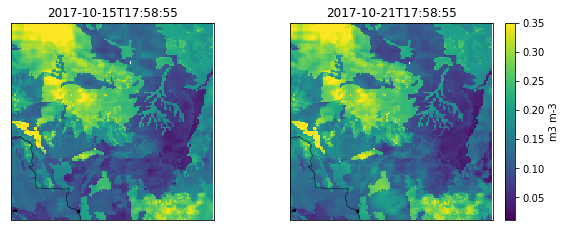

In [13]:
make_image(lon_gr,lat_gr,soil_gr,date,grosso_north, grosso_south,grosso_west, grosso_east, unit, data_later = soil_later,date_later = date_later)

Finally, let's delete files we downloaded:

In [14]:
if os.path.exists(filename_s_america):
    os.remove(filename_s_america)
if os.path.exists(filename_mato_grosso):
    os.remove(filename_mato_grosso)